In [26]:
import pandas as pd
import rdflib
# Map of entity type to dedupe.io fields
ENTITY_FIELDS = {
    "Person": [
        {'field': 'knowsLanguage', 'type': 'String'},
        {'field': 'jobTitle', 'type': 'String'},
        {'field': 'name', 'type': 'String'},
        {'field': 'birthDate', 'type': 'String'},
        {'field': 'gender', 'type': 'String'},
        {'field': 'email', 'type': 'String'}
    ],
    "ContactPoint": [
        {'field': 'faxNumber', 'type': 'String'},
        {'field': 'availableLanguage', 'type': 'String'},
        {'field': 'telephone', 'type': 'String'},
        {'field': 'email', 'type': 'String'},
        {'field': 'contactType', 'type': 'String'}
    ],
    "ServiceDepartment": [
        {'field': 'name', 'type': 'String'}
    ],
    "Address": [
        {'field': 'addressLocality', 'type': 'String'},
        {'field': 'streetAddress', 'type': 'String'},
        {'field': 'postalCode', 'type': 'String'},
        {'field': 'addressCountry', 'type': 'String'}
    ],
    "HealthcareOrganization": [
        {'field': 'name', 'type': 'String'}
    ]
}

import dedupe
import dedupe.variables

ENTITY_FIELDS_dedup= {"Person": [
        dedupe.variables.String("knowsLanguage"),
        dedupe.variables.String("jobTitle", has_missing=True),
        dedupe.variables.String("name", has_missing=True),
        dedupe.variables.String("birthDate", has_missing=True),
        dedupe.variables.String("gender"),
        dedupe.variables.String("email", has_missing=True)
    ],
    "ContactPoint": [
        dedupe.variables.String("faxNumber", has_missing=True),
        dedupe.variables.String("availableLanguage"),
        dedupe.variables.String("telephone"),
        dedupe.variables.String("email"),
        dedupe.variables.String("contactType", has_missing=True)
    ],
    "Department": [
        dedupe.variables.String("name", has_missing=True)
    ],
    "PostalAddress": [
        dedupe.variables.String("addressLocality", has_missing=True),
        dedupe.variables.String("streetAddress"),
        dedupe.variables.String("postalCode", has_missing=True),
        dedupe.variables.String("addressCountry")
    ],
    "MedicalOrganization": [
        dedupe.variables.String("name", has_missing=True)
    ]}





In [31]:
from modular_methods.graphToText_utils import kg_to_dedupe_dict
g = rdflib.Graph() # Main graph
g1 = rdflib.Graph() # Replaced low graph
g2 = rdflib.Graph() # Train graph
g3 = rdflib.Graph() # Replaced medium graph
g4 = rdflib.Graph() # Replaced high graph
g5 = rdflib.Graph() # Struct low graph
g6 = rdflib.Graph() # Struct high graph
g7 = rdflib.Graph() # Struct train_low graph
g8 = rdflib.Graph() # Struct train_high graph

g.parse("data/healthcare_graph_Main.ttl")
g1.parse("data/healthcare_graph_replaced_low.ttl")
g2.parse("data/healthcare_graph_train.ttl")
g3.parse("data/healthcare_graph_replaced_medium.ttl")
g4.parse("data/healthcare_graph_replaced_high.ttl")
g5.parse("data/healthcare_graph_struct_low.ttl")
g6.parse("data/healthcare_graph_struct_high.ttl")
g7.parse("data/healthcare_graph_train_struct_low.ttl")
g8.parse("data/healthcare_graph_train_struct_high.ttl")
dict_main = kg_to_dedupe_dict(g)
dict_low = kg_to_dedupe_dict(g1)
train_dict = kg_to_dedupe_dict(g2)
dict_medium = kg_to_dedupe_dict(g3)
dict_high = kg_to_dedupe_dict(g4)
dict_struct_low = kg_to_dedupe_dict(g5)
dict_struct_high = kg_to_dedupe_dict(g6)
dict_struct_train_low = kg_to_dedupe_dict(g7)
dict_struct_train_high = kg_to_dedupe_dict(g8)   







def fill_missing_fields(record, required_fields):
    for f in required_fields:
        if f not in record:
            record[f] = None
    return record

def get_type_from_uri(uri):
    # This assumes the type is always in the URI after the domain, e.g. http://example.org/Person/...
    return uri.split('/')[-2] if '/' in uri else None

complete_dicts = {
    "dict_struct_low": dict_struct_low,
    "dict_struct_high": dict_struct_high,
    "dict_struct_train_low": dict_struct_train_low,
    "dict_struct_train_high": dict_struct_train_high
} 
for dict in complete_dicts:
    for uri, record in complete_dicts[dict].items():
        entity_type = get_type_from_uri(uri)
        if entity_type in ENTITY_FIELDS:
            required_fields = [f['field'] for f in ENTITY_FIELDS[entity_type]]
            complete_dicts[dict][uri] = fill_missing_fields(record, required_fields)
        else:
            print(f"Warning: Entity type {entity_type} not found in ENTITY_FIELDS for URI {uri}")




In [32]:
dict_struct_low

{'http://example.org/ServiceDepartment/eb823ab0-5b4a-4a00-a329-0aac6baf033e': {'name': 'Public Health'},
 'http://example.org/Person/1b56dbde-b505-4e0b-9c46-a81736693d64': {'gender': 'Male',
  'jobTitle': 'Epidemiologist',
  'knowsLanguage': 'nl',
  'name': 'Jacqueline Williams',
  'birthDate': None,
  'email': None},
 'http://example.org/Person/4e3e1a0d-2396-43bf-b48f-877bcbe8b4c4': {'gender': 'Other',
  'jobTitle': 'CT Scan Technician',
  'knowsLanguage': 'et',
  'name': 'Heather Hogan',
  'birthDate': None,
  'email': None},
 'http://example.org/Person/9dfb221a-f24a-444c-b463-8a2d73a95379': {'gender': 'Female',
  'jobTitle': 'GI Nurse',
  'knowsLanguage': 'de',
  'name': 'David Estrada',
  'birthDate': None,
  'email': None},
 'http://example.org/Person/a51dac1e-e516-4881-a94e-2aa86cf4beac': {'gender': 'Female',
  'jobTitle': 'Optician',
  'knowsLanguage': 'et',
  'name': 'Kristi Henderson',
  'birthDate': None,
  'email': None},
 'http://example.org/ContactPoint/5d1f0045-734f-4710-

In [35]:
def filter_entity(d, entity_type):
    search_str = f"/{entity_type}/"
    return {k: v for k, v in d.items() if search_str in k}


person_main = filter_entity(dict_main, "Person")
person_low = filter_entity(dict_low, "Person")
person_medium = filter_entity(dict_medium, "Person")
person_high = filter_entity(dict_high, "Person")
person_struct_low = filter_entity(dict_struct_low, "Person")
person_struct_high = filter_entity(dict_struct_high, "Person")
train_person_dict1 = filter_entity(train_dict, "Person")
train_person_low = filter_entity(dict_struct_train_low, "Person")
train_person_high = filter_entity(dict_struct_train_high, "Person")

contactpoint_main = filter_entity(dict_main, "ContactPoint")
contactpoint_low = filter_entity(dict_low, "ContactPoint")
contactpoint_medium = filter_entity(dict_medium, "ContactPoint")
contactpoint_high = filter_entity(dict_high, "ContactPoint")
contactpoint_struct_low = filter_entity(dict_struct_low, "ContactPoint")
contactpoint_struct_high = filter_entity(dict_struct_high, "ContactPoint")
train_contactpoint_dict1 = filter_entity(train_dict, "ContactPoint")
train_contactpoint_low = filter_entity(dict_struct_train_low, "ContactPoint")
train_contactpoint_high = filter_entity(dict_struct_train_high, "ContactPoint")

address_main = filter_entity(dict_main, "Address")
address_low = filter_entity(dict_low, "Address")
address_medium = filter_entity(dict_medium, "Address")
address_high = filter_entity(dict_high, "Address")
address_struct_low = filter_entity(dict_struct_low, "Address")
address_struct_high = filter_entity(dict_struct_high, "Address")
train_address_dict1 = filter_entity(train_dict, "Address")
train_address_low = filter_entity(dict_struct_train_low, "Address")
train_address_high = filter_entity(dict_struct_train_high, "Address")

hco_main = filter_entity(dict_main, "HealthcareOrganization")
hco_low = filter_entity(dict_low, "HealthcareOrganization")
hco_medium = filter_entity(dict_medium, "HealthcareOrganization")
hco_high = filter_entity(dict_high, "HealthcareOrganization")
hco_struct_low = filter_entity(dict_struct_low, "HealthcareOrganization")
hco_struct_high = filter_entity(dict_struct_high, "HealthcareOrganization")
train_hco_dict1 = filter_entity(train_dict, "HealthcareOrganization")
train_hco_low = filter_entity(dict_struct_train_low, "HealthcareOrganization")
train_hco_high = filter_entity(dict_struct_train_high, "HealthcareOrganization")

sd_main = filter_entity(dict_main, "ServiceDepartment")
sd_low = filter_entity(dict_low, "ServiceDepartment")
sd_medium = filter_entity(dict_medium, "ServiceDepartment")
sd_high = filter_entity(dict_high, "ServiceDepartment")
sd_struct_low = filter_entity(dict_struct_low, "ServiceDepartment")
sd_struct_high = filter_entity(dict_struct_high, "ServiceDepartment")
train_sd_dict1 = filter_entity(train_dict, "ServiceDepartment")
train_sd_low = filter_entity(dict_struct_train_low, "ServiceDepartment")
train_sd_high = filter_entity(dict_struct_train_high, "ServiceDepartment")





In [45]:
person_struct_low

{'http://example.org/Person/1b56dbde-b505-4e0b-9c46-a81736693d64': {'gender': 'Male',
  'jobTitle': 'Epidemiologist',
  'knowsLanguage': 'nl',
  'name': 'Jacqueline Williams',
  'birthDate': None,
  'email': None},
 'http://example.org/Person/4e3e1a0d-2396-43bf-b48f-877bcbe8b4c4': {'gender': 'Other',
  'jobTitle': 'CT Scan Technician',
  'knowsLanguage': 'et',
  'name': 'Heather Hogan',
  'birthDate': None,
  'email': None},
 'http://example.org/Person/9dfb221a-f24a-444c-b463-8a2d73a95379': {'gender': 'Female',
  'jobTitle': 'GI Nurse',
  'knowsLanguage': 'de',
  'name': 'David Estrada',
  'birthDate': None,
  'email': None},
 'http://example.org/Person/a51dac1e-e516-4881-a94e-2aa86cf4beac': {'gender': 'Female',
  'jobTitle': 'Optician',
  'knowsLanguage': 'et',
  'name': 'Kristi Henderson',
  'birthDate': None,
  'email': None},
 'http://example.org/Person/8069c669-88b0-47d0-8a3c-ac377f7d149f': {'gender': 'Female',
  'jobTitle': 'Infectious Disease Specialist',
  'knowsLanguage': 'de'

In [34]:
import csv



def read_pairs_from_csv(filename):
    """Read pairs of records from a CSV file (after manual annotation), converting empty fields to None."""
    pairs = []
    labels = []
    with open(filename, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            
            rec1 = {k[5:]: (v if v.strip() != '' else None) for k, v in row.items() if k.startswith('left_')}
            rec2 = {k[6:]: (v if v.strip() != '' else None) for k, v in row.items() if k.startswith('right_')}
            label = row.get('label', '')
            pairs.append((rec1, rec2))
            labels.append(label)
    return pairs, labels




matches = read_pairs_from_csv('data/dedupe_data/labelling_train/matches_for_labelling_Person.csv')
distinct = read_pairs_from_csv('data/dedupe_data/labelling_train/distinct_pairs_for_labelling_Person.csv')



matches[0]



[({'birthDate': '1993-10-10',
   'email': 'stephenmiller@healthcare.org',
   'gender': 'Male',
   'jobTitle': 'Doula',
   'knowsLanguage': 'et',
   'name': 'Stephen Miller'},
  {'birthDate': '1993-10-10',
   'email': 'stephenmiller@healthcare.org',
   'gender': 'Male',
   'jobTitle': 'Doula',
   'knowsLanguage': 'et',
   'name': 'Stephen Minler'}),
 ({'birthDate': '1973-06-08',
   'email': 'carlfisher@healthcare.org',
   'gender': 'Male',
   'jobTitle': 'ENT Specialist',
   'knowsLanguage': 'nl',
   'name': 'Carl Fisher'},
  {'birthDate': '1973-06-08',
   'email': 'carlfihser@healthcare.org',
   'gender': 'Male',
   'jobTitle': 'ENT Specialist',
   'knowsLanguage': 'nl',
   'name': 'Carl Fisier'}),
 ({'birthDate': '1976-06-08',
   'email': 'tanyamalone@healthcare.org',
   'gender': 'Male',
   'jobTitle': 'Vision Therapist',
   'knowsLanguage': 'et',
   'name': 'Tanya Malone'},
  {'birthDate': '1976-06-08',
   'email': 'tanydamalone@healthcare.org',
   'gender': 'Male',
   'jobTitle': '

In [36]:

training_data = {
    "match": matches[0],
    "distinct": distinct[0],
}


In [37]:
matches[0]

[({'birthDate': '1993-10-10',
   'email': 'stephenmiller@healthcare.org',
   'gender': 'Male',
   'jobTitle': 'Doula',
   'knowsLanguage': 'et',
   'name': 'Stephen Miller'},
  {'birthDate': '1993-10-10',
   'email': 'stephenmiller@healthcare.org',
   'gender': 'Male',
   'jobTitle': 'Doula',
   'knowsLanguage': 'et',
   'name': 'Stephen Minler'}),
 ({'birthDate': '1973-06-08',
   'email': 'carlfisher@healthcare.org',
   'gender': 'Male',
   'jobTitle': 'ENT Specialist',
   'knowsLanguage': 'nl',
   'name': 'Carl Fisher'},
  {'birthDate': '1973-06-08',
   'email': 'carlfihser@healthcare.org',
   'gender': 'Male',
   'jobTitle': 'ENT Specialist',
   'knowsLanguage': 'nl',
   'name': 'Carl Fisier'}),
 ({'birthDate': '1976-06-08',
   'email': 'tanyamalone@healthcare.org',
   'gender': 'Male',
   'jobTitle': 'Vision Therapist',
   'knowsLanguage': 'et',
   'name': 'Tanya Malone'},
  {'birthDate': '1976-06-08',
   'email': 'tanydamalone@healthcare.org',
   'gender': 'Male',
   'jobTitle': '

In [41]:

linker = dedupe.RecordLink(ENTITY_FIELDS_dedup['Person'])
linker.mark_pairs(training_data)
linker.prepare_training(person_main, train_person_low, sample_size=400)
linker.train()

In [68]:
links = linker.join(person_main, person_struct_low, threshold=0.5)
#list(links)


In [69]:
list(links)
pairs = [ (str(pair[0][0]), str(pair[0][1])) for pair in links ]

In [70]:
pairs

[('http://example.org/Person/ffdbf61f-bb4b-451f-b3aa-90815cabce60',
  'http://example.org/Person/5abee759-f7e0-4770-8593-1151f087585a'),
 ('http://example.org/Person/ff6b8936-156a-455f-a8dd-66aa5e928c94',
  'http://example.org/Person/62c34ee7-65fe-460d-bb87-425449bc740d'),
 ('http://example.org/Person/ff6581ca-1748-4b1c-9d61-b002011b529e',
  'http://example.org/Person/f9322eec-f07b-44b8-affb-2c5cac5e6c23'),
 ('http://example.org/Person/fec73137-0e94-4750-9858-ae084794f991',
  'http://example.org/Person/a51dac1e-e516-4881-a94e-2aa86cf4beac'),
 ('http://example.org/Person/fe362397-6bc2-4163-9369-32fcec1c4d5c',
  'http://example.org/Person/172650bf-a510-494a-9259-4588c2fa94e6'),
 ('http://example.org/Person/fd1ec008-2575-4290-bfa6-65bfdff5199e',
  'http://example.org/Person/bc279a44-550c-4193-b358-846d2b9e7805'),
 ('http://example.org/Person/fc914bbb-995e-4fcd-ab15-f0b575dd770d',
  'http://example.org/Person/28ccb4f6-4a3f-46b5-8be2-37d60e837a3b'),
 ('http://example.org/Person/fc63b1fb-102

In [78]:
extracted_pairs = set(
    (str(pair[0][0]).rsplit('/', 1)[-1], str(pair[0][1]).rsplit('/', 1)[-1])
    for pair in links
)
extracted_pairs



golden_record = pd.read_csv('data/dedupe_data/ground_truths_test/test_golden_standard_struct_low_GT_Person.csv')
test_GT_Person = golden_record[['uri1', 'uri2']].values.tolist()

golden_pairs = set(
    (a.rsplit('/', 1)[-1], b.rsplit('/', 1)[-1])
    for a, b in test_GT_Person
)


found = extracted_pairs & golden_pairs

In [80]:
len(found)

395

In [73]:
golden_pairs

{('0116d36e-bba3-48dc-b6a1-521655d2309b',
  '70cadd8f-7b40-4451-bbf9-b39e7b990a68'),
 ('01396d1a-8cec-4b63-b9fd-ae736f40bcfc',
  '3b00c9f5-8a7c-4c14-8047-bed376681d4b'),
 ('01b7a7c7-d2a9-483e-b3a3-6fc5de974c55',
  '684bff02-4556-42d7-b6ba-dda584162cd1'),
 ('021d14e0-9899-43f4-b54d-f31abc6121cb',
  'dafa9bdd-b13f-4344-a5e1-4a75aefece7a'),
 ('0362d0d2-a71e-4258-b0bb-d427fb9fe536',
  '3b696e7c-e5ad-43ac-bac9-9606b191346e'),
 ('0395edd8-10a0-41e4-81bc-9e48e84ddfc8',
  '0b3accf9-2326-4496-abfb-d2d9dc26a27e'),
 ('03b08689-1357-4ea1-8cfe-cbc12dcfea01',
  'de4cb327-10a0-476f-9a14-e392f9356224'),
 ('053f06dd-2915-47a9-b4a1-c7ad481214bd',
  '9543312c-cbdd-49a4-9cea-0c56952ffb17'),
 ('057141b1-aabc-451f-bc91-05ee6c752883',
  'adcf807c-971e-4aa0-bd38-f54221ba2f66'),
 ('059b0583-fde2-4f93-8e6f-1ca7271e2d2f',
  '0bcfeedd-d05c-41ea-8ae2-c932d9af4420'),
 ('06722257-bde3-4232-82d5-afa942d09119',
  'e444b71c-565a-447c-9f67-a4d0de6ec0fd'),
 ('06ea3809-a312-4f0d-94e9-9b77fae76dd2',
  '01a0af87-50a4-438e-a

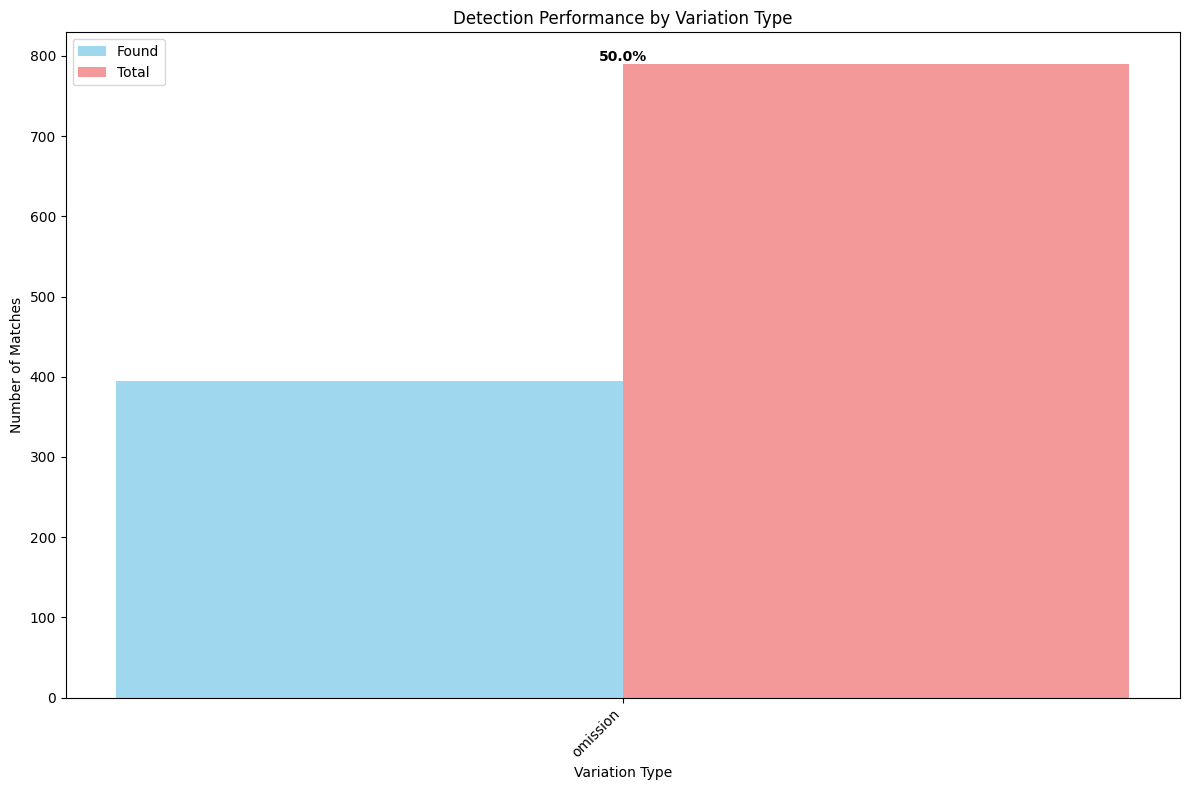

Detection Results by Variation Type:
--------------------------------------------------
omission                  | 395/790 ( 50.0%)
--------------------------------------------------
Overall                   | 395/790 ( 50.0%)


In [81]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the golden standard data
golden_standard = pd.read_csv('data/test_golden_standard_struct_low.csv')

# Replace entity types to match your test data format
golden_standard['entity_type'] = golden_standard['entity_type'].replace({
    'HealthcareOrganization': 'HealthcareOrg',
    'ServiceDepartment': 'ServiceDept'
})

# Filter for Person entities (including HealthcarePersonnel)
person_variations = golden_standard[
    (golden_standard['entity_type'] == 'Person') | 
    (golden_standard['entity_type'] == 'HealthcarePersonnel')
]

# Create a mapping from ID pairs to variation types
variation_lookup = {}
for _, row in person_variations.iterrows():
    key = (row['original_id'], row['duplicate_id'])
    variation_lookup[key] = row['variation_type']

# Convert your found results back to ID pairs
# Assuming 'found' contains tuples like ('id1', 'id2')
found_with_variation = {}

for pair in found:
    if pair in variation_lookup:
        var_type = variation_lookup[pair]
        if var_type not in found_with_variation:
            found_with_variation[var_type] = 0
        found_with_variation[var_type] += 1

# Calculate totals for each variation type
variation_totals = {}
for var_type in person_variations['variation_type'].unique():
    variation_totals[var_type] = len(person_variations[person_variations['variation_type'] == var_type])

# Prepare data for plotting
variation_types = list(variation_totals.keys())
found_counts = [found_with_variation.get(vt, 0) for vt in variation_types]
total_counts = [variation_totals[vt] for vt in variation_types]

# Create the visualization
fig, ax = plt.subplots(figsize=(12, 8))

x = range(len(variation_types))
width = 0.35

bars1 = ax.bar([i - width/2 for i in x], found_counts, width, label='Found', alpha=0.8, color='skyblue')
bars2 = ax.bar([i + width/2 for i in x], total_counts, width, label='Total', alpha=0.8, color='lightcoral')

# Add percentage labels on bars
for i, (found, total) in enumerate(zip(found_counts, total_counts)):
    percentage = (found / total * 100) if total > 0 else 0
    ax.text(i, max(found, total) + 0.5, f'{percentage:.1f}%', 
            ha='center', va='bottom', fontweight='bold')

ax.set_xlabel('Variation Type')
ax.set_ylabel('Number of Matches')
ax.set_title('Detection Performance by Variation Type')
ax.set_xticks(x)
ax.set_xticklabels(variation_types, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

# Print detailed results
print("Detection Results by Variation Type:")
print("-" * 50)
for var_type in variation_types:
    found_count = found_with_variation.get(var_type, 0)
    total_count = variation_totals[var_type]
    percentage = (found_count / total_count * 100) if total_count > 0 else 0
    print(f"{var_type:25} | {found_count:3d}/{total_count:3d} ({percentage:5.1f}%)")

print("-" * 50)
total_found = sum(found_counts)
total_possible = sum(total_counts)
overall_percentage = (total_found / total_possible * 100) if total_possible > 0 else 0
print(f"{'Overall':25} | {total_found:3d}/{total_possible:3d} ({overall_percentage:5.1f}%)")

In [ ]:
import pandas as pd 
golden_standard = pd.read_csv('data/test_golden_standard_low_updated.csv')


golden_standard_subset = golden_standard[['original_id', 'duplicate_id', 'entity_type']]
golden_standard_subset_var = golden_standard[['original_id', 'duplicate_id', 'entity_type','variation_type']]


ground_truth_test = {}

# Mapping to Person for both Person and HealthcarePersonnel
for entity in golden_standard_subset_var['entity_type'].unique():
    df_filtered = golden_standard_subset_var[golden_standard_subset_var['entity_type'] == entity]
    entity_for_uri = "Person" if entity in ["Person", "HealthcarePersonnel"] else entity
    # Use 'Person' as the key for both types
    key = "Person" if entity in ["Person", "HealthcarePersonnel"] else entity
    if key not in ground_truth_test:
        ground_truth_test[key] = []
    ground_truth_test[key].extend([
        (f"http://example.org/{entity_for_uri}/{row['original_id']}", 
         f"http://example.org/{entity_for_uri}/{row['duplicate_id']}")
        for _, row in df_filtered.iterrows()
    ])

test_GT_Person = ground_truth_test['Person']
test_GT_HealthcareOrg = ground_truth_test['HealthcareOrg']
test_GT_ServiceDept = ground_truth_test['ServiceDept']
test_GT_Address = ground_truth_test['Address']
test_GT_ContactPoint = ground_truth_test['ContactPoint']

In [ ]:
import random


def sample_distinct_pairs(golden_standard_subset, ground_truth_pairs, entity_type, n_neg=3):
    """Sample distinct pairs for dedupe.io (negatives), avoiding ground truth."""
    filtered = golden_standard_subset[golden_standard_subset['entity_type'] == entity_type]
    all_ids1 = filtered['original_id'].unique()
    all_ids2 = filtered['duplicate_id'].unique()
    gt_set = set(ground_truth_pairs)
    distinct_pairs = set()
    attempts = 0
    max_attempts = len(gt_set) * n_neg * 10  # Prevent infinite loop
    
    while len(distinct_pairs) < len(gt_set) * n_neg and attempts < max_attempts:
        a, b = random.choice(all_ids1), random.choice(all_ids2)
        if (a, b) not in gt_set and (b, a) not in gt_set and (a, b) not in distinct_pairs:
            distinct_pairs.add((f"http://example.org/{entity_type}/{a}", f"http://example.org/{entity_type}/{b}"))
        attempts += 1
    return list(distinct_pairs)


for file in train_gs_files:
    golden_standard = pd.read_csv(file)
    golden_standard_subset = golden_standard[['original_id', 'duplicate_id', 'entity_type','variation_type']]
    entity_types = ['Address', 'Person', 'HealthcareOrg', 'ServiceDept', 'ContactPoint']
    distinct_pairs = {}
    for entity_type in entity_types:
        negatives = sample_distinct_pairs(
            golden_standard_subset, ground_truth_train[entity_type], entity_type, n_neg=3
        )
        distinct_pairs[entity_type] = negatives

DP_Ad = distinct_pairs['Address'][:20]   
DP_Person = distinct_pairs['Person'][:20]
DP_HCO = distinct_pairs['HealthcareOrg'][:20]
DP_SD = distinct_pairs['ServiceDept'][:20]
DP_CP = distinct_pairs['ContactPoint'][:20]
